In [21]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

import os
import sys
import annoy
from annoy import AnnoyIndex
import random
import itertools



from IPython.display import display_markdown

from collections import Counter

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA


import antares_client

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# set random seed for consistent results
import random
random.seed(0)

plt.style.use('fig_publication.mplstyle')
%config InlineBackend.figure_format = 'retina'  #for MacOS, make plots crisp

In [22]:
#TODO: add more suffixes and make plots!
# Specifically with nohostdownweighted and see...

In [23]:
#suffix="noTNScut_pca35_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_addJiterNorm0p05" #
#suffix="noTNScut_pca35_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_addJiterNorm0p02" #

#suffix="noTNScut_pca35_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_addJiterNorm0p01" #
#suffix="noTNScut_pca35_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_addJiterNorm0p1" # need smaller jitter
#suffix="noTNScut_pca35_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" # !! Really nice. Same/better results with less PCs. 98% var.
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" #really v good, better than 35pca (best PC implementation)

#suffix="noTNScut_pca35_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_direct_output_SMOTE_80-20"

#suffix="noTNScut_pca60_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_NOfw_SMOTE_80-20" # amazing sim search. 99%var. AD is quite good, maybe 2nd or 3rd best. Maybe overall best when considering both!
#suffix="noTNScut_pca60_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_NOfw_SMOTE_80-20_v2" # amazing sim search. 99%var. AD is quite good, maybe 2nd or 3rd best. Maybe overall best when considering both!


smote_suffix = 'SMOTE_train_test_80-20_min8_kneighbors5'
#smote_suffix = 'SMOTE_train_test_80-20_min8_kneighbors5_addJitterNorm0p01'
#smote_suffix = 'SMOTE_train_test_80-20_min8_kneighbors5_addJitterNorm0p02'
suffix=f"noTNScut_pca60_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_NOfw_{smote_suffix}"

In [24]:
# dataset_bank_pca = pd.read_csv(f'../dataframes/{suffix}_dataset_bank_pca.csv', compression='gzip', index_col=0)
# dataset_bank_test = pd.read_csv(f'../dataframes/{suffix}_dataset_bank_pca_test.csv', compression='gzip', index_col=0)
# dataset_bank_orig = pd.read_pickle('../dataframes/dataset_label_orig_SMOTE_train_test_80-20_v2.pkl')

#dataset_bank_orig = pd.read_pickle('../dataframes/dataset_label_orig_SMOTE_train_test_80-20_addJiterNorm0p02.pkl')

dataset_bank_pca = pd.read_csv(f'../loci_dbs/alerce_cut/{suffix}_dataset_bank_pca.csv.gz', compression='gzip', index_col=0)
dataset_bank_test = pd.read_csv(f'../loci_dbs/alerce_cut/{suffix}_dataset_bank_pca_test.csv.gz', compression='gzip', index_col=0)
dataset_bank_orig = pd.read_pickle(f'../loci_dbs/alerce_cut/dataset_label_orig_{smote_suffix}.pkl')



full_ann_properties_df = pd.read_csv(f'../loci_dbs/alerce_cut/full_ann101_properties_df_{suffix}.csv', index_col=0)
#full_ann_properties_df = pd.read_csv(f'../dataframes/full_ann_properties_df_{suffix}.csv', index_col=0)


In [25]:
dataset_bank_test['tns_cls'] = full_ann_properties_df['ann=0_tns_cls']

dataset_bank_pca['tns_cls'] = dataset_bank_orig
dataset_bank_pca

PC0       PC1       PC2       PC3       PC4       PC5  \
ztf_object_id                                                               
ZTF21achsafa  -3.534681 -3.617795 -0.138720  0.801350  1.269341  1.984520   
ZTF21aapllew   0.351679 -1.577476 -5.826144  2.123224  0.519168  0.939999   
ZTF20acpgnsn   7.822792 -3.536476  1.765171 -1.589456  1.489354  1.192004   
ZTF21abcjacg  -3.578557 -4.791885  1.151038  0.621174  2.388201  4.056232   
ZTF21acjelll  -5.955139 -5.875364 -1.474969  0.042297  3.233317  0.087977   
...                 ...       ...       ...       ...       ...       ...   
ZTFabc59055   -6.065893  2.058777  0.252200  3.249571  1.813673  0.003406   
ZTFabc91877   -2.641317  5.831781  0.873997  0.040660  2.684812 -1.191349   
ZTFabc95043   -6.510586  0.763008  0.783216  2.726502  1.484709 -1.047415   
ZTFabc33622   -5.275259  3.265089  1.175388  0.258338  1.810365 -0.672203   
ZTFabc12100   -2.576490 -0.270481  1.448090  1.081877 -1.236264 -1.116990   

                    PC6       PC7       PC8       PC9  ...      PC51  \
ztf_object_id                                          ...             
ZTF21achsafa  -0.218079  0.556672 -1.132455  1.484533  ...  0.154006   
ZTF21aapllew   0.030884  0.993095  0.240508 -0.379591  ...  0.247045   
ZTF20acpgnsn  -0.191118  0.367435  3.396364  0.040110  ...  0.954765   
ZTF21abcjacg  -3.640109 -1.784660  2.362085 -3.795171  ... -0.280999   
ZTF21acjelll   0.340411 -0.861745  3.008623 -0.918106  ...  1.028945   
...                 ...       ...       ...       ...  ...       ...   
ZTFabc59055    0.032855 -0.624048 -2.071956  0.672947  ... -0.156826   
ZTFabc91877    0.852343 -0.535433 -1.137129  1.509960  ... -0.130499   
ZTFabc95043    0.033704 -1.149541 -1.636921  0.401967  ... -0.000149   
ZTFabc33622   -3.509394  1.185908 -2.525216  4.327069  ... -0.228984   
ZTFabc12100   -2.650892  3.190186 -2.133501 -0.344991  ... -0.487457   

                   PC52      PC53      PC54      PC55      PC56      PC57  \
ztf_object_id                                                               
ZTF21achsafa   0.308830  0.229725  0.194537  0.062193  0.170182  0.198569   
ZTF21aapllew   1.022709  0.869670 -0.119284  0.304546 -0.185379 -0.131730   
ZTF20acpgnsn   0.293934  0.127269  0.082552 -0.206840  0.399205  0.060314   
ZTF21abcjacg  -0.675956 -0.687706  0.396679 -0.010181 -0.030425  0.292735   
ZTF21acjelll   0.044572 -0.120651  0.752237 -0.414953  0.061389  0.490383   
...                 ...       ...       ...       ...       ...       ...   
ZTFabc59055    0.109643  0.103322  0.217305  0.059783 -0.109530 -0.094502   
ZTFabc91877    0.239382  0.046772  0.679514  0.404865 -0.402923 -0.336305   
ZTFabc95043   -0.103282 -0.084989  0.183368  0.244649 -0.245794 -0.127407   
ZTFabc33622    0.356886 -0.242576  0.255348  0.226859 -0.180911 -0.275866   
ZTFabc12100   -0.363928 -0.593485  0.009945 -0.439895  0.524647 -0.597107   

                   PC58      PC59  tns_cls  
ztf_object_id                               
ZTF21achsafa   0.741891  0.129885     None  
ZTF21aapllew   0.743633  0.181601     None  
ZTF20acpgnsn   0.652186  0.057455    SN Ia  
ZTF21abcjacg  -0.184221 -1.429964     None  
ZTF21acjelll  -0.371443 -0.361925     None  
...                 ...       ...      ...  
ZTFabc59055    0.154656 -0.512982      TDE  
ZTFabc91877   -0.495373  0.196921      TDE  
ZTFabc95043   -0.093537  0.323717      TDE  
ZTFabc33622    0.079354 -0.409989      TDE  
ZTFabc12100   -0.141882 -0.190778      TDE  

[45885 rows x 61 columns]

In [30]:
#fakes_suffix = 'SMOTE_train_test_80-20_min14_kneighbors8'
fakes_suffix = 'SMOTE_train_test_70-30_min14_kneighbors8'
#suffix=f"noTNScut_pca60_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_NOfw_{smote_suffix}"
#dataset_bank_tns_df_resampled_train = pd.read_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_resampled_train_{smote_suffix}.csv.gz', compression='gzip', index_col=0)
#dataset_bank_tns_df_resampled_test = pd.read_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_resampled_test_{smote_suffix}.csv.gz', compression='gzip', index_col=0)

#num=3039 #5000
#n_classes=11 #12
#n_epochs=4000 #500
#fakes_suffix = f'PZFLOW_train_test_70-30_min14_classes{n_classes}_epochs{n_epochs}'
#fakes_suffix = f'PZFLOW_train_test_80-20_min14_classes{n_classes}_epochs{n_epochs}_n{num}'
#fakes_suffix = f'PZFLOW_train_test_80-20_min14_classes{n_classes}_epochs{n_epochs}_n{num}_RollingSplineCoupling_B=5'
#fakes_suffix = f'PZFLOW_train_test_80-20_min14_classes{n_classes}_epochs{n_epochs}_n{num}_RollingSplineCoupling_B=5_chunks20'

suffix=f"noTNScut_pca60_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_NOfw_{fakes_suffix}"

#dataset_bank_tns_df_resampled_train = pd.read_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_resampled_train_{fakes_suffix}.csv.gz', compression='gzip', index_col=0)
#dataset_bank_tns_df_resampled_test = pd.read_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_resampled_test_{fakes_suffix}.csv.gz', compression='gzip', index_col=0)

df_folder_path = f"../figures/CVAE/SMOTE_train_test_70-30_min14_kneighbors8/256_epochs=250_latent_dim=3_10000xClassLoss/dataframes/"
# Files used for actual model gen    
#x_train_all_latent_df = pd.read_csv(f'{df_folder_path}/x_train_all_3sdims_df.csv.gz', compression='gzip', index_col=0)
#x_test_all_latent_df = pd.read_csv(f'{df_folder_path}/x_test_all_3sdims_df.csv.gz', compression='gzip', index_col=0)
#dataset_bank_tns_df_resampled_train = x_train_all_latent_df
#dataset_bank_tns_df_resampled_test = x_test_all_latent_df


# test here isn't split into test+val set (val set used for VAE)
dataset_bank_tns_df_resampled_train = pd.read_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_resampled_train_{fakes_suffix}.csv.gz', compression='gzip', index_col=0)
dataset_bank_tns_df_resampled_test = pd.read_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_resampled_test_{fakes_suffix}.csv.gz', compression='gzip', index_col=0)

dataset_bank_tns_df_resampled_train

feature_amplitude_magn_r  \
ztf_object_id                             
ZTF19abvhaqq                   0.391695   
ZTF21aaswtkh                   0.356501   
ZTF18abscghc                   0.224128   
ZTF21abjpjcn                   0.392974   
ZTF21aarhzdh                   0.908470   
...                                 ...   
ZTFabc91973                    0.648056   
ZTFabc46594                    0.486110   
ZTFabc20988                    0.447717   
ZTFabc25754                    0.351957   
ZTFabc81371                    0.445597   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF19abvhaqq                                 0.368108   
ZTF21aaswtkh                                 0.355052   
ZTF18abscghc                                 0.290376   
ZTF21abjpjcn                                 0.806768   
ZTF21aarhzdh                                 0.317764   
...                                               ...   
ZTFabc91973                                  0.438369   
ZTFabc46594                                  0.605627   
ZTFabc20988                                  0.433476   
ZTFabc25754                                  0.541262   
ZTFabc81371                                  0.432874   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF19abvhaqq                      0.375000                     0.000000   
ZTF21aaswtkh                      0.300000                     0.000000   
ZTF18abscghc                      0.400000                     0.000000   
ZTF21abjpjcn                      0.142857                     0.142857   
ZTF21aarhzdh                      0.263158                     0.000000   
...                                    ...                          ...   
ZTFabc91973                       0.306405                     0.000000   
ZTFabc46594                       0.258561                     0.017279   
ZTFabc20988                       0.428571                     0.000000   
ZTFabc25754                       0.343006                     0.012478   
ZTFabc81371                       0.428571                     0.000000   

               feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ztf_object_id                                                                  
ZTF19abvhaqq               0.395856                                 0.783390   
ZTF21aaswtkh               0.321765                                 0.713001   
ZTF18abscghc               0.345730                                 0.448256   
ZTF21abjpjcn               0.316430                                 0.785948   
ZTF21aarhzdh               0.397708                                 1.816940   
...                             ...                                      ...   
ZTFabc91973                0.350863                                 1.296113   
ZTFabc46594                0.317578                                 0.937265   
ZTFabc20988                0.403265                                 0.895435   
ZTFabc25754                0.327531                                 0.678671   
ZTFabc81371                0.403129                                 0.891194   

               feature_inter_percentile_range_10_magn_r  \
ztf_object_id                                             
ZTF19abvhaqq                                   0.723513   
ZTF21aaswtkh                                   0.551514   
ZTF18abscghc                                   0.448256   
ZTF21abjpjcn                                   0.671357   
ZTF21aarhzdh                                   1.555440   
...                                                 ...   
ZTFabc91973                                    1.132292   
ZTFabc46594                                    0.604629   
ZTFabc20988                                    0.820801   
ZTFabc25754                                    

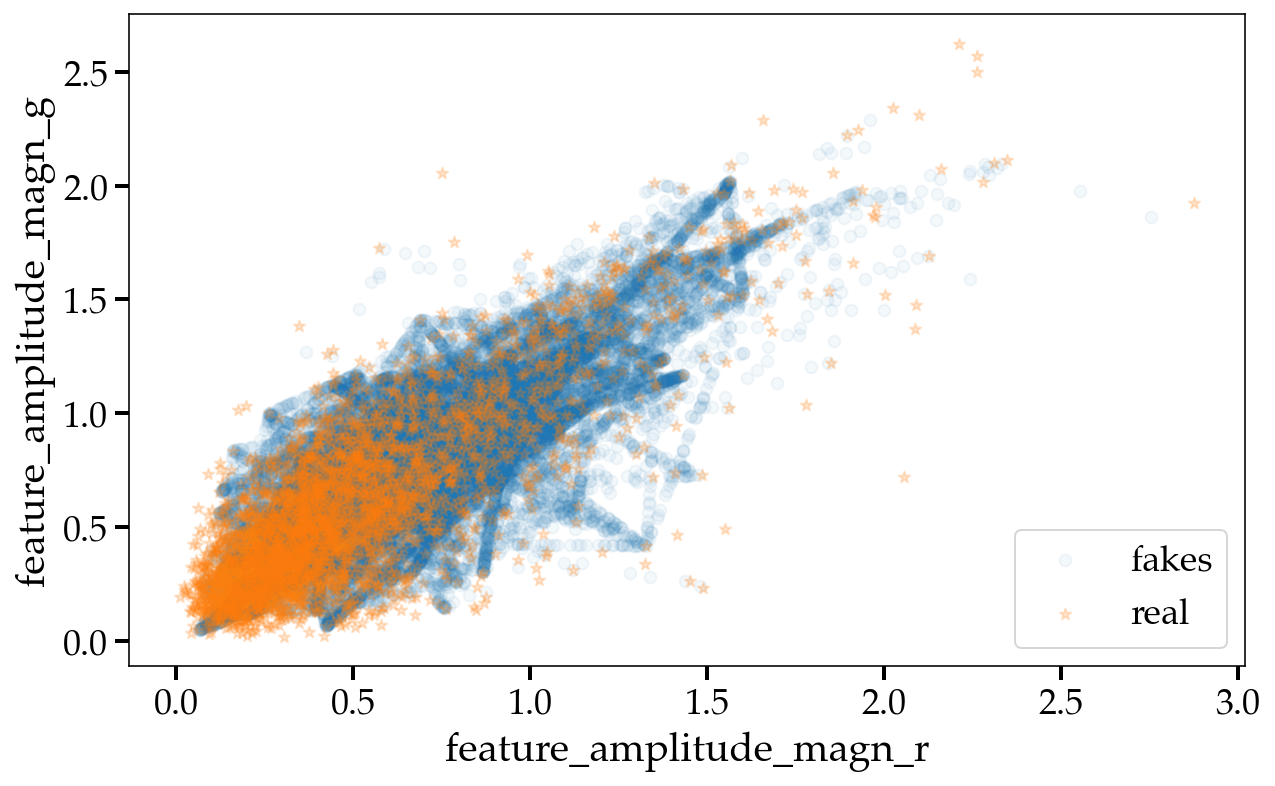

In [34]:
fig, ax = plt.subplots(figsize=(10, 6))

# Split into real/fakes
real_df = dataset_bank_tns_df_resampled_train[~dataset_bank_tns_df_resampled_train.index.str.startswith('ZTFabc')]
fakes_df = dataset_bank_tns_df_resampled_train[dataset_bank_tns_df_resampled_train.index.str.startswith('ZTFabc')]

ax.scatter(fakes_df['feature_amplitude_magn_r'], fakes_df['feature_amplitude_magn_g'], alpha=0.05, marker='o', label='fakes')
ax.scatter(real_df['feature_amplitude_magn_r'], real_df['feature_amplitude_magn_g'], alpha=0.2, marker='*',label='real')

plt.xlabel('feature_amplitude_magn_r')
plt.ylabel('feature_amplitude_magn_g')

#plt.xlim(-15, 20)
#plt.ylim(-15, 25)

plt.legend(loc='lower right')
#plt.savefig(f'../figures/principal_components/{suffix}/fakes_vs_real.jpg', dpi=250, bbox_inches='tight')

plt.show()

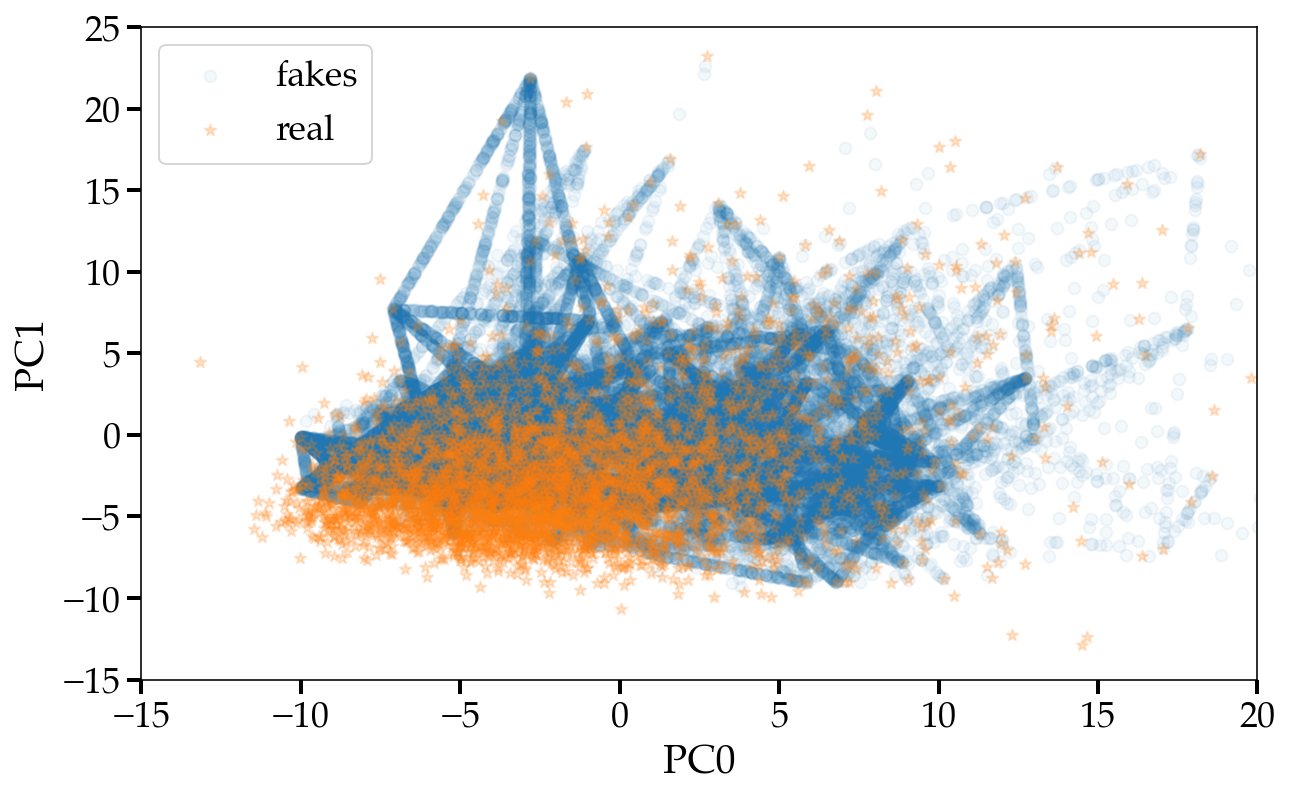

In [29]:
fig, ax = plt.subplots(figsize=(10, 6))

# Split into real/fakes
real_df = dataset_bank_pca[~dataset_bank_pca.index.str.startswith('ZTFabc')]
fakes_df = dataset_bank_pca[dataset_bank_pca.index.str.startswith('ZTFabc')]

ax.scatter(fakes_df['PC0'], fakes_df['PC1'], alpha=0.05, marker='o', label='fakes')
ax.scatter(real_df['PC0'], real_df['PC1'], alpha=0.2, marker='*',label='real')

plt.xlabel('PC0')
plt.ylabel('PC1')

plt.xlim(-15, 20)
plt.ylim(-15, 25)

plt.legend()
plt.savefig(f'../figures/principal_components/{suffix}/fakes_vs_real.jpg', dpi=250, bbox_inches='tight')

plt.show()

In [47]:
marker = itertools.cycle(('.', ',', 'o', 'v', '^','<', '>', '1', '2', '3', '4', '8', 's', 'p', 'P', 'h', "H", '+', "x", 'X', 'D', 'd')) 

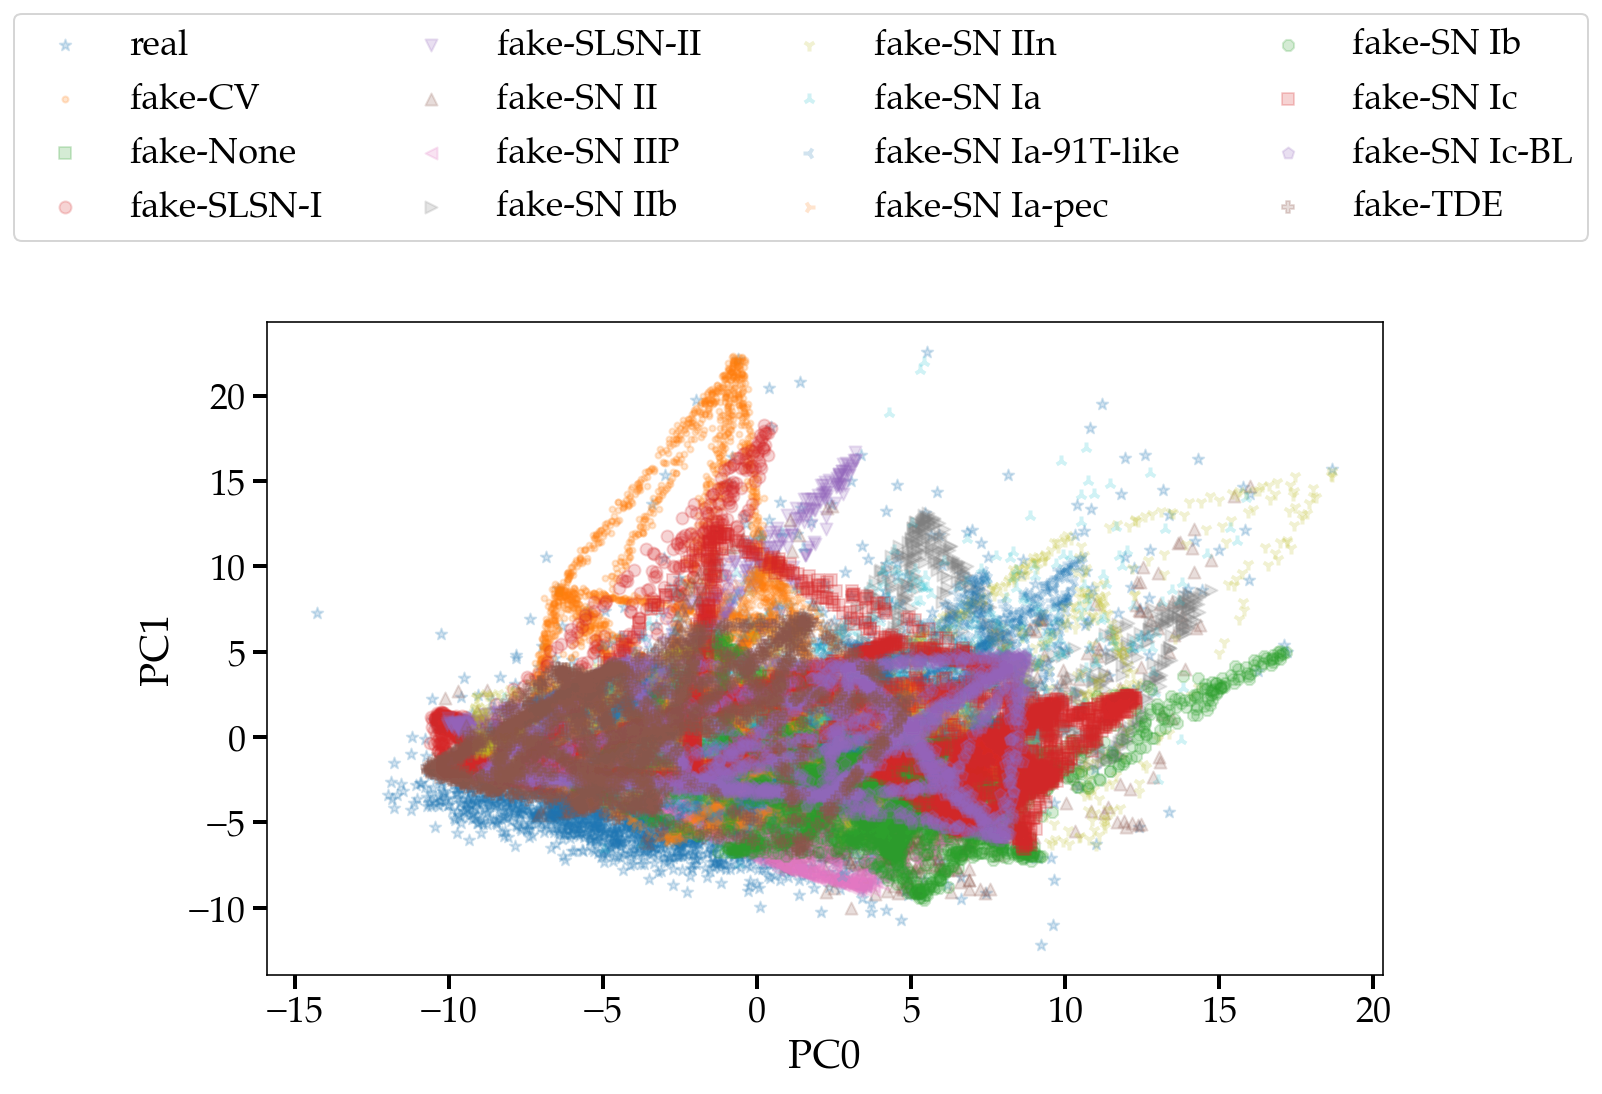

In [48]:
fig, ax = plt.subplots(figsize=(10, 6))

# Split into real/fakes
real_df = dataset_bank_pca[~dataset_bank_pca.index.str.startswith('ZTFabc')]
fakes_df = dataset_bank_pca[dataset_bank_pca.index.str.startswith('ZTFabc')]

ax.scatter(real_df['PC0'], real_df['PC1'], alpha=0.2, marker='*',label='real')

marker_l = ['.', ',', 'o', 'v', '^','<', '>', '1', '2', '3', '4', '8', 's', 'p', 'P', 'h', "H", '+', "x", 'X', 'D', 'd', '|'] 
for marker, cls in zip(marker_l, np.unique(dataset_bank_pca.tns_cls)):
    fakes_cls_df = fakes_df[fakes_df.tns_cls == cls]
    ax.scatter(fakes_cls_df['PC0'], fakes_cls_df['PC1'], alpha=0.2, marker=marker, label=f'fake-{cls}')

plt.xlabel('PC0')
plt.ylabel('PC1')

plt.legend(ncol=4, bbox_to_anchor=(1.2, 1.5))

folder_path = f"../figures/principal_components/{suffix}"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

plt.savefig(f'../figures/principal_components/{suffix}/fakes_cls_df.jpg', dpi=250, bbox_inches='tight')
plt.show()

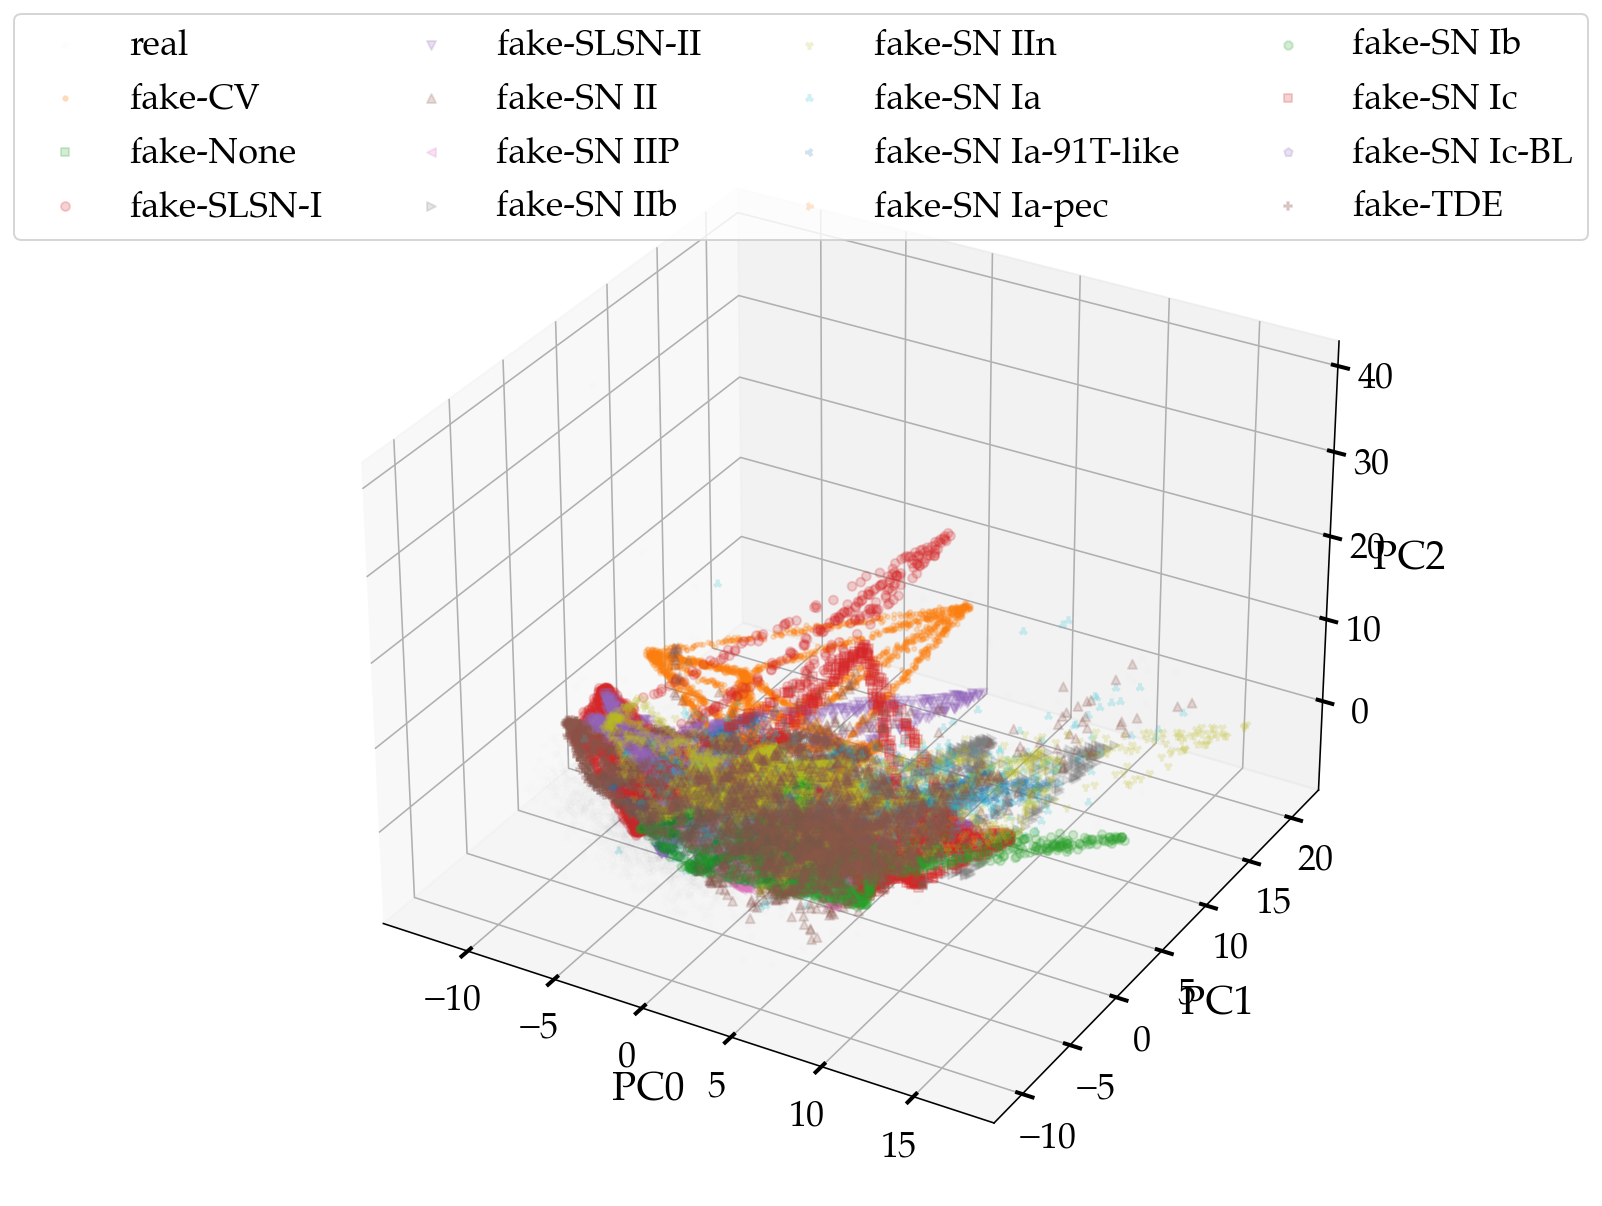

In [49]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Split into real/fakes
real_df = dataset_bank_pca[~dataset_bank_pca.index.str.startswith('ZTFabc')]
fakes_df = dataset_bank_pca[dataset_bank_pca.index.str.startswith('ZTFabc')]

ax.scatter(real_df['PC0'], real_df['PC1'], real_df['PC2'], alpha=0.005, marker='*',label='real')

marker_l = ['.', ',', 'o', 'v', '^','<', '>', '1', '2', '3', '4', '8', 's', 'p', 'P', 'h', "H", '+', "x", 'X', 'D', 'd', '|'] 
for marker, cls in zip(marker_l, np.unique(dataset_bank_pca.tns_cls)):
    fakes_cls_df = fakes_df[fakes_df.tns_cls == cls]
    ax.scatter(fakes_cls_df['PC0'], fakes_cls_df['PC1'], fakes_cls_df['PC2'], alpha=0.2, marker=marker, label=f'fake-{cls}')

# Set axis limits
ax.set_xlim(real_df['PC0'].min(), real_df['PC0'].max())
ax.set_ylim(real_df['PC1'].min(), real_df['PC1'].max())
ax.set_zlim(real_df['PC2'].min(), real_df['PC2'].max())    
    
ax.set_xlabel('PC0')
ax.set_ylabel('PC1')
ax.set_zlabel('PC2')

plt.legend(ncol=4, bbox_to_anchor=(1.2, 1.1))

folder_path = f"../figures/principal_components/{suffix}"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

plt.savefig(f'../figures/principal_components/{suffix}/fakes_cls_df_3D.jpg', dpi=250, bbox_inches='tight')
plt.show()

In [50]:
# not upsampling None (no fakes), and few Ia fakes, so fakes doesn't cover all regions
# But fakes does cover outlier regions
# streaks are from extreme upsampling of O(few) instances of minority classes with 2knn

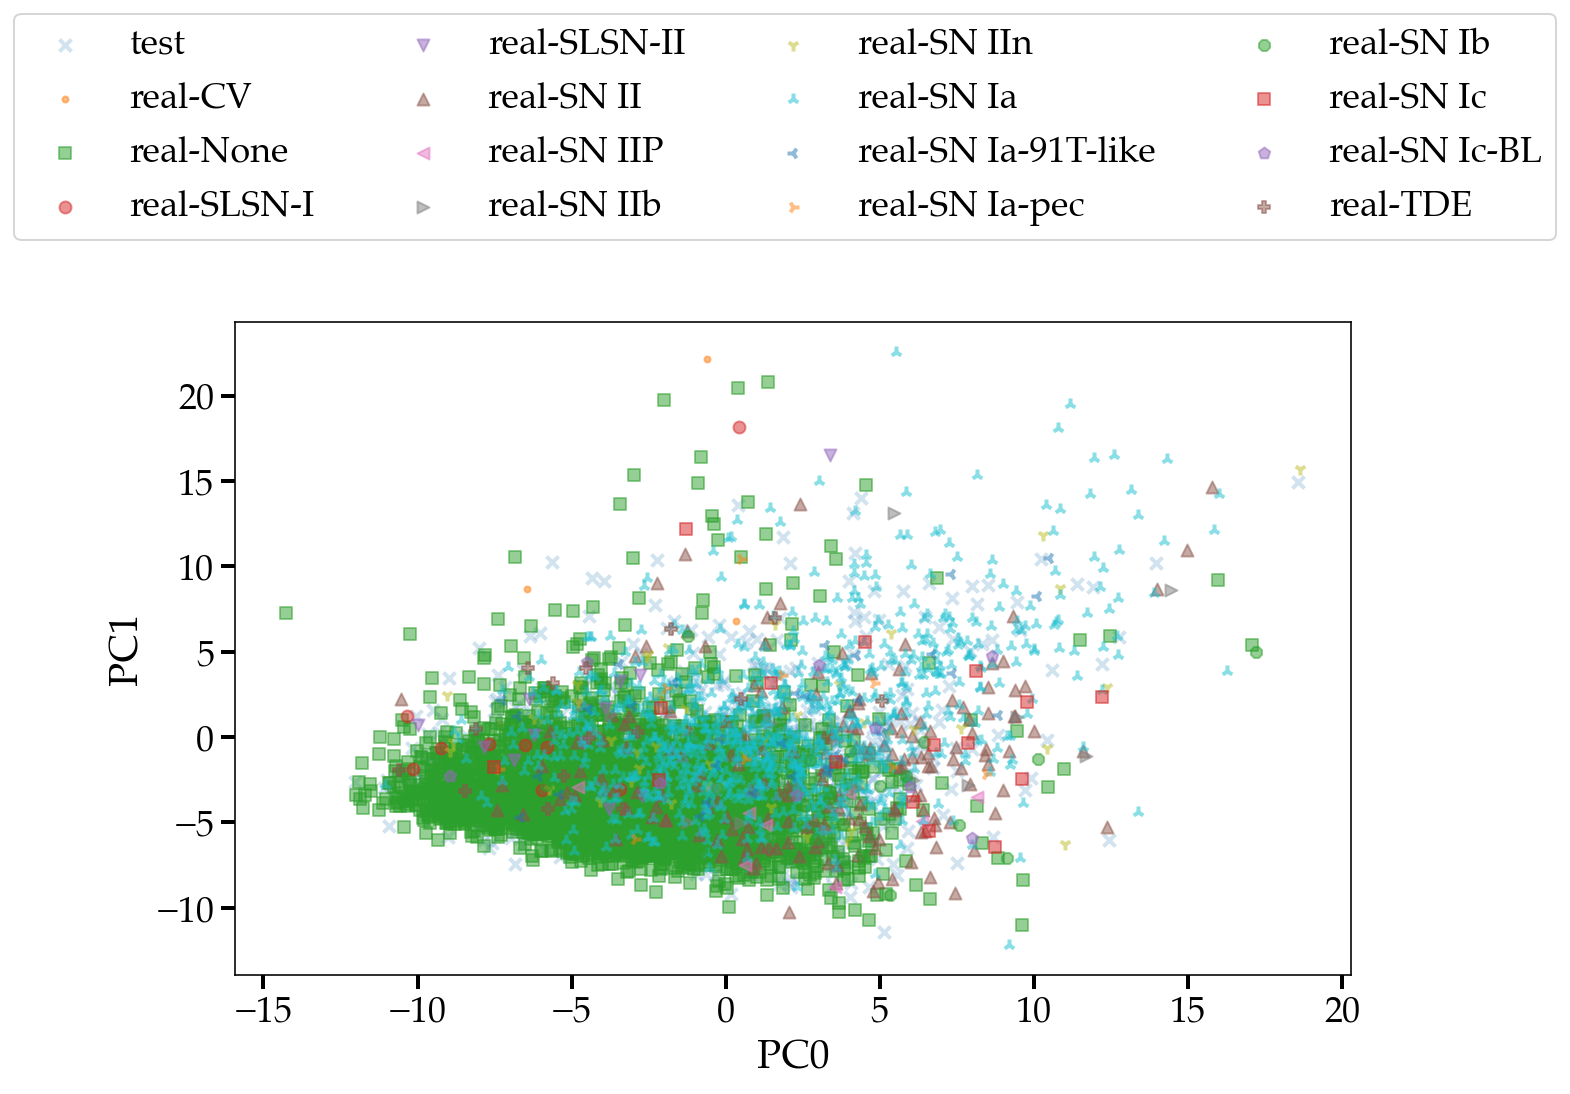

In [51]:
fig, ax = plt.subplots(figsize=(10, 6))

# Split into real/fakes
real_df = dataset_bank_pca[~dataset_bank_pca.index.str.startswith('ZTFabc')]
test_df = dataset_bank_test

ax.scatter(test_df['PC0'], test_df['PC1'], alpha=0.2, marker='x',label='test')


marker_l = ['.', ',', 'o', 'v', '^','<', '>', '1', '2', '3', '4', '8', 's', 'p', 'P', 'h', "H", '+', "x", 'X', 'D', 'd', '|'] 
for marker, cls in zip(marker_l, np.unique(dataset_bank_pca.tns_cls)):
    real_cls_df = real_df[real_df.tns_cls == cls]
    ax.scatter(real_cls_df['PC0'], real_cls_df['PC1'], alpha=0.5, marker=marker, label=f'real-{cls}')

#ax.scatter(real_df['PC0'], real_df['PC1'], alpha=0.2, marker='*',label='real')
#ax.scatter(test_df['PC0'], test_df['PC1'], alpha=0.05, marker='x',label='test')

plt.xlabel('PC0')
plt.ylabel('PC1')

plt.legend(ncol=4, bbox_to_anchor=(1.2, 1.5))
plt.savefig(f'../figures/principal_components/{suffix}/real_cls_df.jpg', dpi=250, bbox_inches='tight')
plt.show()

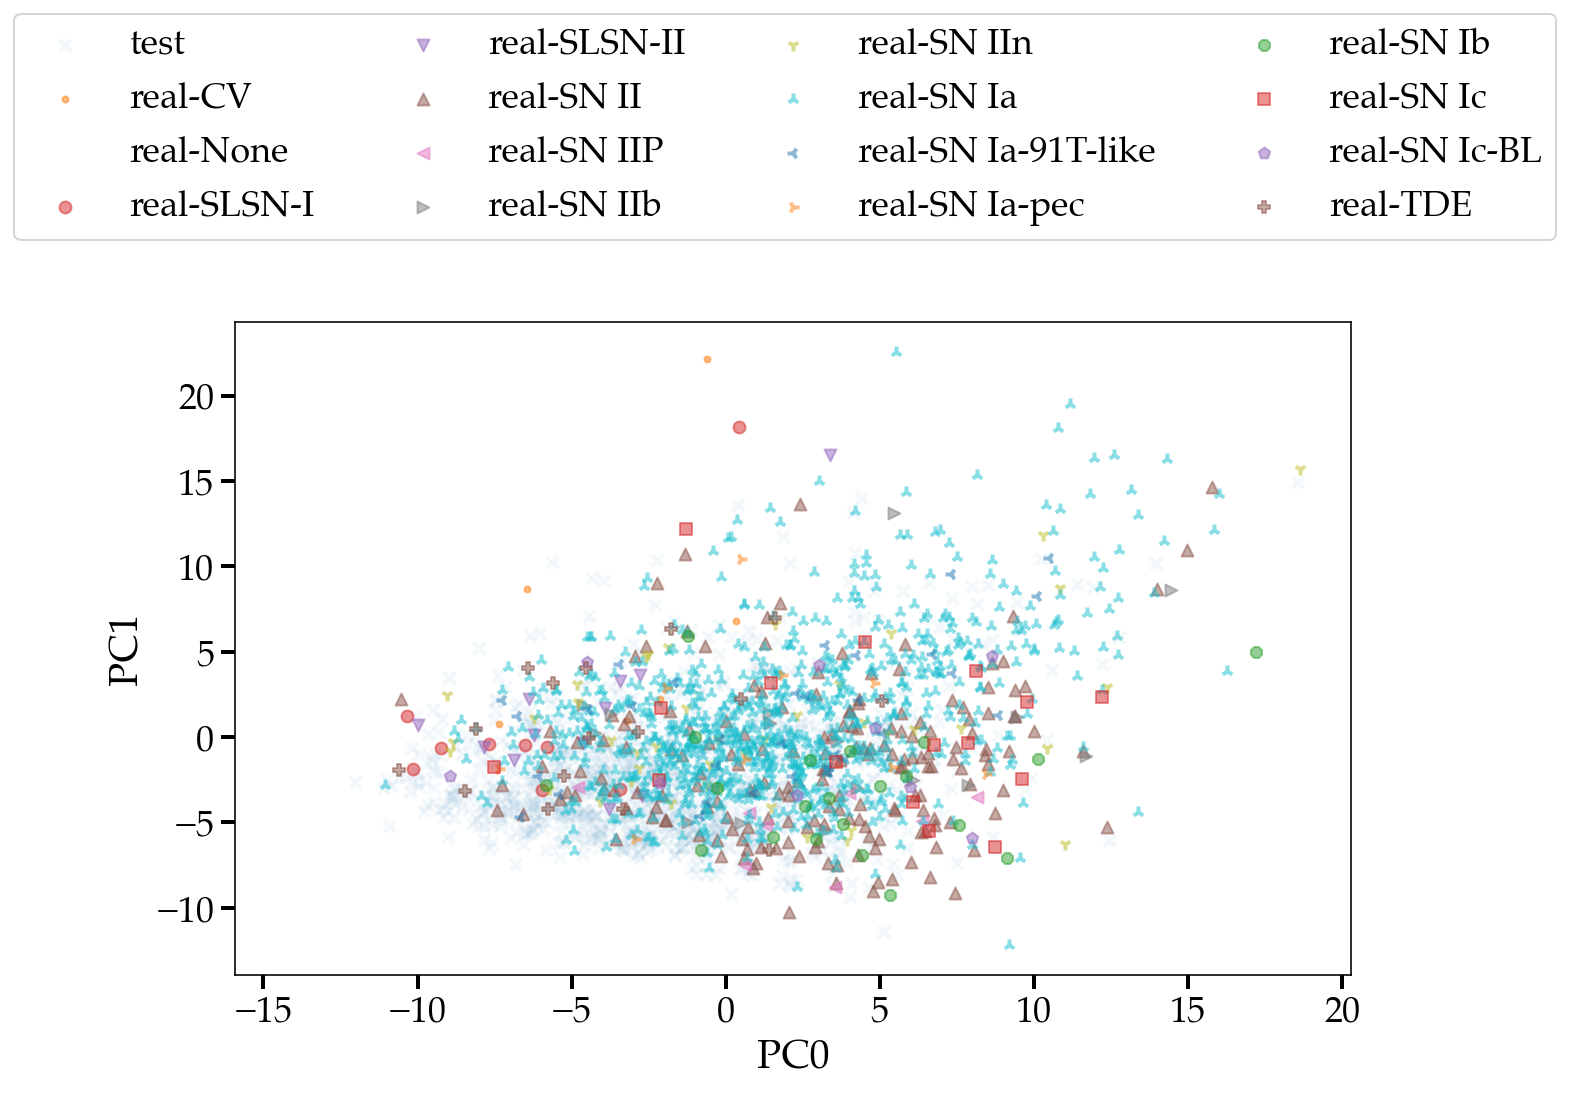

In [52]:
fig, ax = plt.subplots(figsize=(10, 6))

# Split into real/fakes
real_df = dataset_bank_pca[~dataset_bank_pca.index.str.startswith('ZTFabc')]
test_df = dataset_bank_test

ax.scatter(test_df['PC0'], test_df['PC1'], alpha=0.05, marker='x',label='test')


marker_l = ['.', ',', 'o', 'v', '^','<', '>', '1', '2', '3', '4', '8', 's', 'p', 'P', 'h', "H", '+', "x", 'X', 'D', 'd', '|'] 
for marker, cls in zip(marker_l, np.unique(dataset_bank_pca.tns_cls)):
    real_cls_df = real_df[real_df.tns_cls == cls]
    
    if cls == 'None': ax.scatter(real_cls_df['PC0'], real_cls_df['PC1'], alpha=0.0, marker=marker, label=f'real-{cls}')
    else: ax.scatter(real_cls_df['PC0'], real_cls_df['PC1'], alpha=0.5, marker=marker, label=f'real-{cls}')

#ax.scatter(real_df['PC0'], real_df['PC1'], alpha=0.2, marker='*',label='real')
#ax.scatter(test_df['PC0'], test_df['PC1'], alpha=0.05, marker='x',label='test')

plt.xlabel('PC0')
plt.ylabel('PC1')

plt.legend(ncol=4, bbox_to_anchor=(1.2, 1.5))
plt.savefig(f'../figures/principal_components/{suffix}/real_cls_df_no_real.jpg', dpi=250, bbox_inches='tight')
plt.show()

### Add convex hull

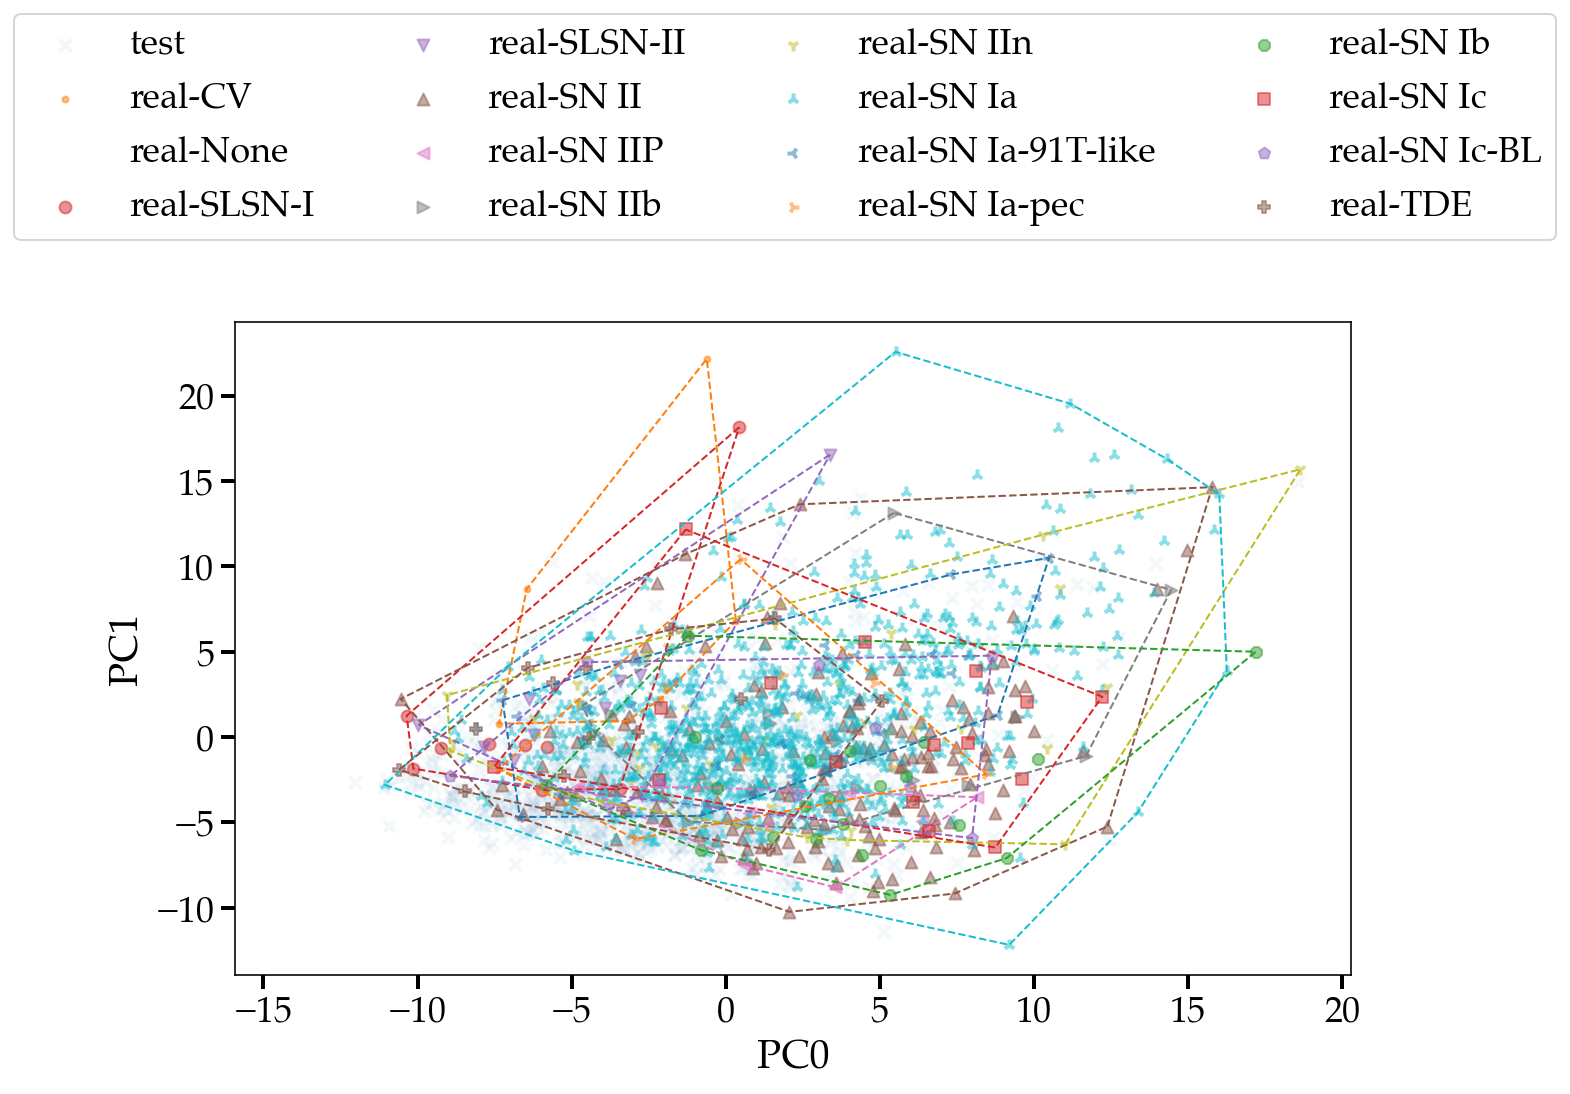

In [53]:
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from matplotlib.patches import Polygon
import numpy as np

fig, ax = plt.subplots(figsize=(10, 6))

# Split into real/fakes
real_df = dataset_bank_pca[~dataset_bank_pca.index.str.startswith('ZTFabc')]
test_df = dataset_bank_test

ax.scatter(test_df['PC0'], test_df['PC1'], alpha=0.05, marker='x', label='test')

marker_l = ['.', ',', 'o', 'v', '^', '<', '>', '1', '2', '3', '4', '8', 's', 'p', 'P', 'h', "H", '+', "x", 'X', 'D', 'd', '|']

for marker, cls in zip(marker_l, np.unique(dataset_bank_pca.tns_cls)):
    real_cls_df = real_df[real_df.tns_cls == cls]

    if cls == 'None':
        marker_color = ax.scatter(real_cls_df['PC0'], real_cls_df['PC1'], alpha=0.0, marker=marker, label=f'real-{cls}')
    else:
        marker_color = ax.scatter(real_cls_df['PC0'], real_cls_df['PC1'], alpha=0.5, marker=marker, label=f'real-{cls}').get_facecolor()[0]
        
        # Compute the convex hull
        points = np.column_stack([real_cls_df['PC0'], real_cls_df['PC1']])
        hull = ConvexHull(points)
        
        # Create the patch for the convex hull
        poly = Polygon(points[hull.vertices], edgecolor=marker_color, fill=False, linestyle='--', alpha=1)
        
        # Add the patch to the plot
        ax.add_patch(poly)

plt.xlabel('PC0')
plt.ylabel('PC1')

plt.legend(ncol=4, bbox_to_anchor=(1.2, 1.5))
plt.savefig(f'../figures/principal_components/{suffix}/real_cls_df_no_real_w_convex_hull.jpg', dpi=250, bbox_inches='tight')
plt.show()


# TODO: plot reals classes w/ convex hull and fakes w/ convex hull,
## See how good the overlap is. Do the same with test classes w/ convex hull and fakes w/ convex hull

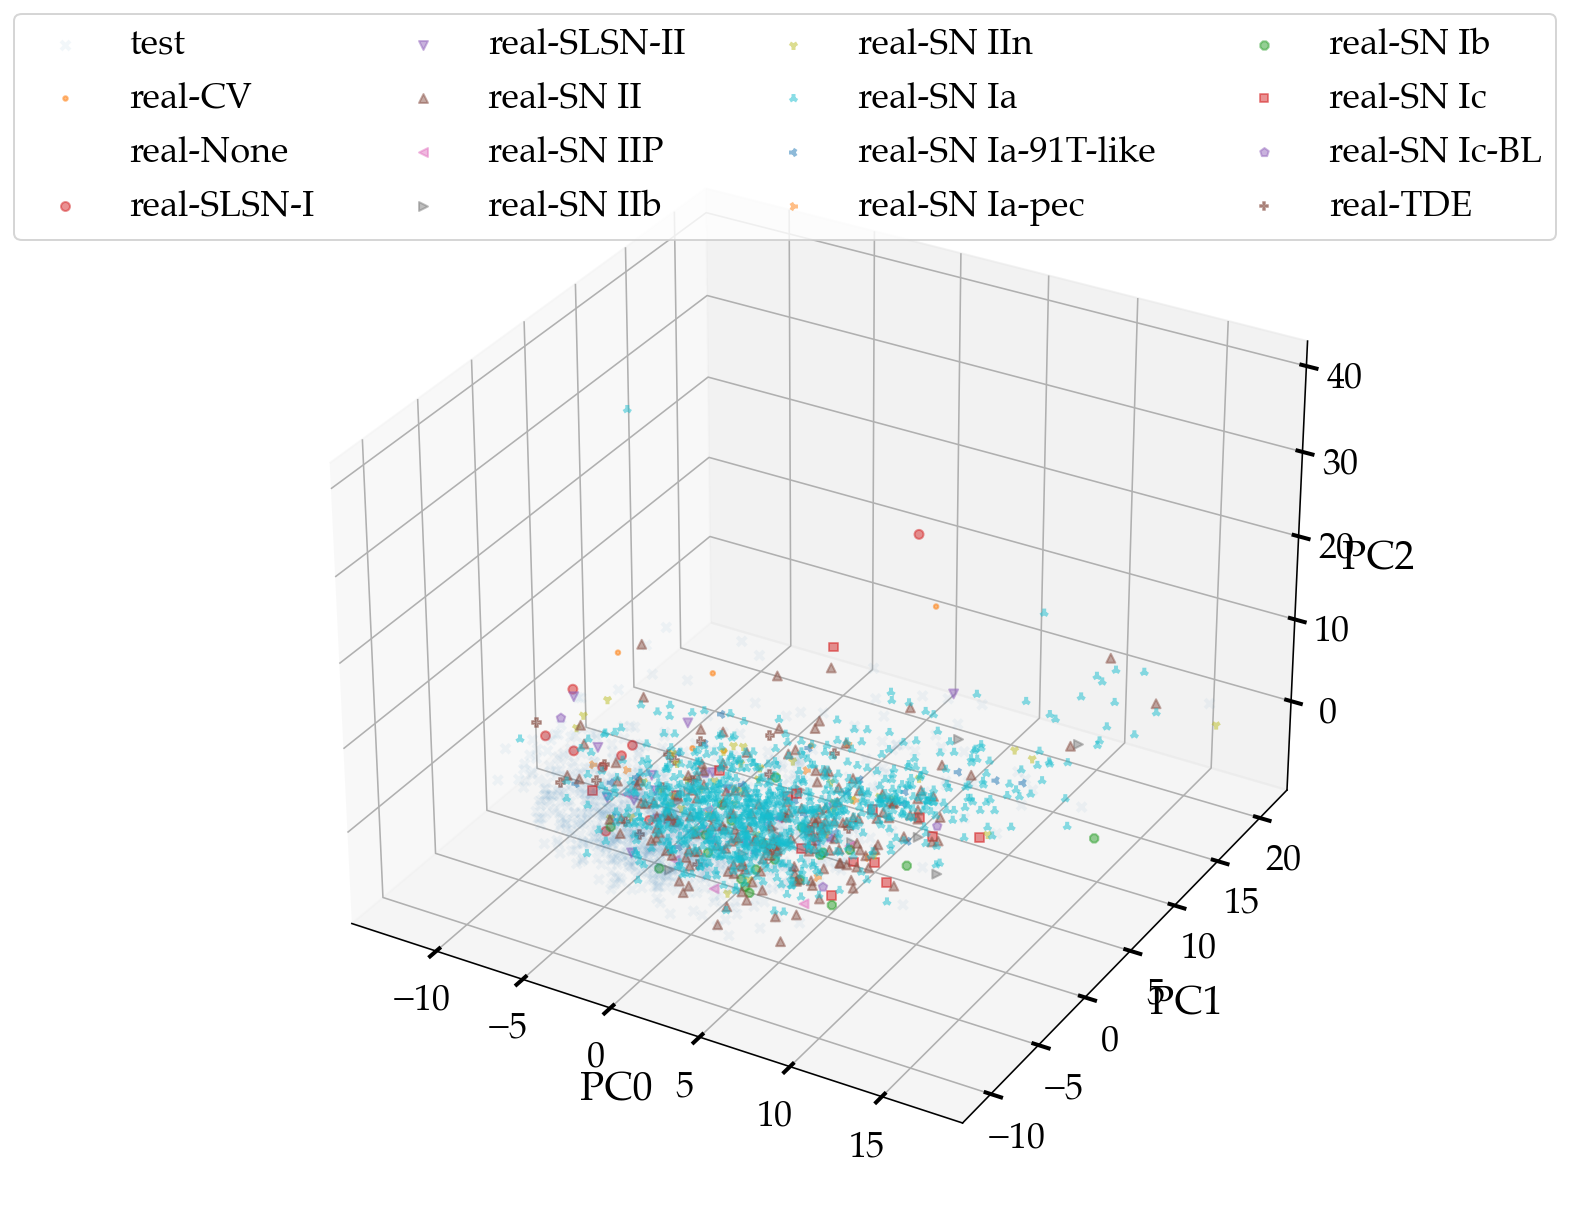

In [54]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Split into real/fakes
real_df = dataset_bank_pca[~dataset_bank_pca.index.str.startswith('ZTFabc')]
test_df = dataset_bank_test

ax.scatter(test_df['PC0'], test_df['PC1'], test_df['PC2'], alpha=0.05, marker='x', label='test')

marker_l = ['.', ',', 'o', 'v', '^','<', '>', '1', '2', '3', '4', '8', 's', 'p', 'P', 'h', "H", '+', "x", 'X', 'D', 'd', '|'] 
for marker, cls in zip(marker_l, np.unique(dataset_bank_pca.tns_cls)):
    real_cls_df = real_df[real_df.tns_cls == cls]
    
    if cls == 'None': ax.scatter(real_cls_df['PC0'], real_cls_df['PC1'], real_cls_df['PC2'], alpha=0.0, marker=marker, label=f'real-{cls}')
    else: ax.scatter(real_cls_df['PC0'], real_cls_df['PC1'], real_cls_df['PC2'], alpha=0.5, marker=marker, label=f'real-{cls}')

# ax.scatter(real_df['PC0'], real_df['PC1'], real_df['PC2'], alpha=0.2, marker='*', label='real')
# ax.scatter(test_df['PC0'], test_df['PC1'], test_df['PC2'], alpha=0.05, marker='x', label='test')

# Set axis limits
ax.set_xlim(real_df['PC0'].min(), real_df['PC0'].max())
ax.set_ylim(real_df['PC1'].min(), real_df['PC1'].max())
ax.set_zlim(real_df['PC2'].min(), real_df['PC2'].max())

ax.set_xlabel('PC0')
ax.set_ylabel('PC1')
ax.set_zlabel('PC2')

plt.legend(ncol=4, bbox_to_anchor=(1.2, 1.1))
plt.savefig(f'../figures/principal_components/{suffix}/real_cls_df_no_real_3D.jpg', dpi=250, bbox_inches='tight')
plt.show()


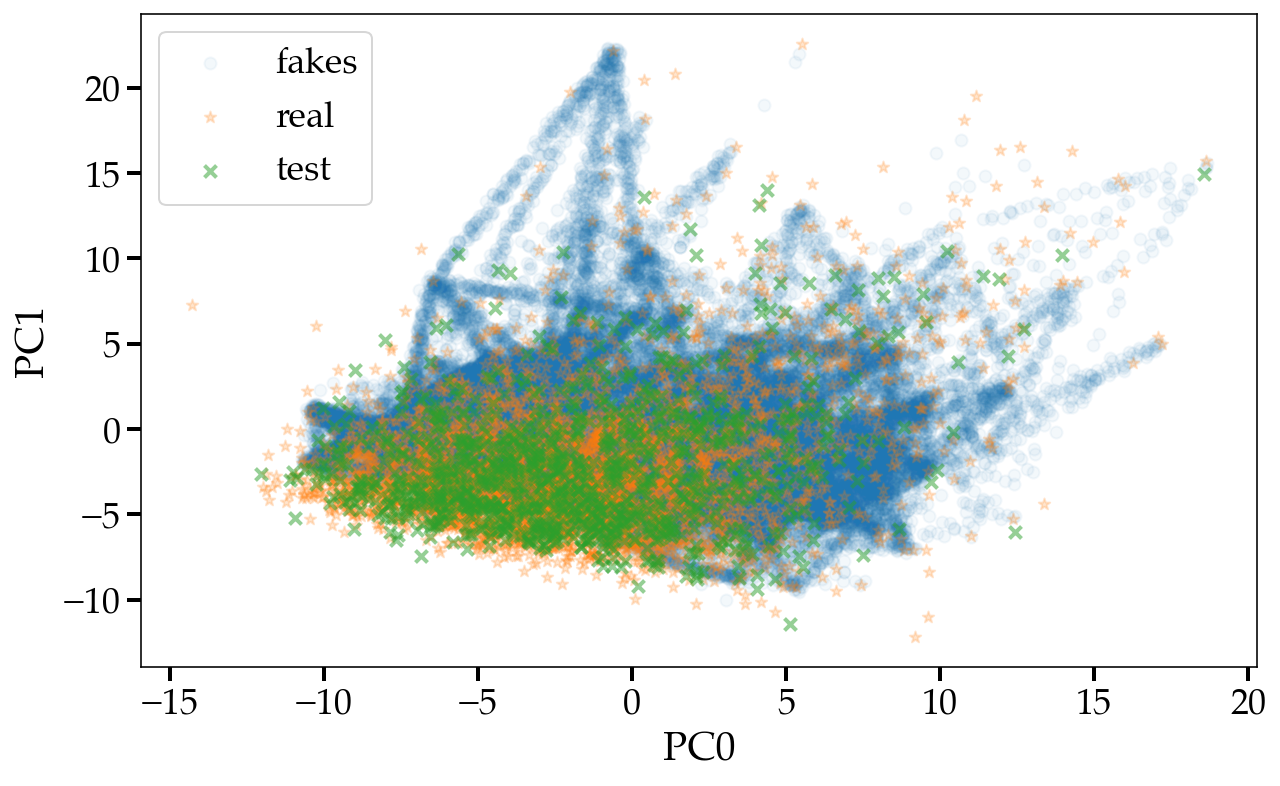

In [55]:
fig, ax = plt.subplots(figsize=(10, 6))

# Split into real/fakes
real_df = dataset_bank_pca[~dataset_bank_pca.index.str.startswith('ZTFabc')]
fakes_df = dataset_bank_pca[dataset_bank_pca.index.str.startswith('ZTFabc')]
test_df = dataset_bank_test

ax.scatter(fakes_df['PC0'], fakes_df['PC1'], alpha=0.05, marker='o', label='fakes')
ax.scatter(real_df['PC0'], real_df['PC1'], alpha=0.2, marker='*',label='real')
ax.scatter(test_df['PC0'], test_df['PC1'], alpha=0.5, marker='x',label='test')

plt.xlabel('PC0')
plt.ylabel('PC1')


folder_path = f"../figures/principal_components/{suffix}"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

plt.legend()
plt.savefig(f'../figures/principal_components/{suffix}/real_vs_fakes_vs_test.jpg', dpi=250, bbox_inches='tight')
plt.show()

In [56]:
#cut_df = test_df[(test_df['PC0'] > 4)]
cut_df = real_df[(real_df['PC0'] > 30)]

cut_df

Empty DataFrame
Columns: [PC0, PC1, PC2, PC3, PC4, PC5, PC6, PC7, PC8, PC9, PC10, PC11, PC12, PC13, PC14, PC15, PC16, PC17, PC18, PC19, PC20, PC21, PC22, PC23, PC24, PC25, PC26, PC27, PC28, PC29, PC30, PC31, PC32, PC33, PC34, PC35, PC36, PC37, PC38, PC39, PC40, PC41, PC42, PC43, PC44, PC45, PC46, PC47, PC48, PC49, PC50, PC51, PC52, PC53, PC54, PC55, PC56, PC57, PC58, PC59, tns_cls]
Index: []

[0 rows x 61 columns]

In [57]:
for sn, cl in zip(cut_df.index, cut_df.tns_cls):
    print(f'https://alerce.online/object/{sn}', cl)

In [58]:
test_df[(test_df['PC0'] > 40)]

Empty DataFrame
Columns: [PC0, PC1, PC2, PC3, PC4, PC5, PC6, PC7, PC8, PC9, PC10, PC11, PC12, PC13, PC14, PC15, PC16, PC17, PC18, PC19, PC20, PC21, PC22, PC23, PC24, PC25, PC26, PC27, PC28, PC29, PC30, PC31, PC32, PC33, PC34, PC35, PC36, PC37, PC38, PC39, PC40, PC41, PC42, PC43, PC44, PC45, PC46, PC47, PC48, PC49, PC50, PC51, PC52, PC53, PC54, PC55, PC56, PC57, PC58, PC59, tns_cls]
Index: []

[0 rows x 61 columns]

In [40]:
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20"

In [20]:
# train/test before smote has same embedding mostly
# smote covers regions it's supposed to

In [15]:
test_df[(test_df['PC0'] > 20) & (test_df['PC1'] < -20)]

Empty DataFrame
Columns: [PC0, PC1, PC2, PC3, PC4, PC5, PC6, PC7, PC8, PC9, PC10, PC11, PC12, PC13, PC14, PC15, PC16, PC17, PC18, PC19, PC20, PC21, PC22, PC23, PC24, PC25, PC26, PC27, PC28, PC29, PC30, PC31, PC32, PC33, PC34, tns_cls]
Index: []

[0 rows x 36 columns]

In [10]:
# https://alerce.online/object/ZTF18abdhozj - remaining periodic var
# https://alerce.online/object/ZTF20acqucpz - remaining CV

In [12]:
real_df[(real_df['PC0'] < -20) & (real_df['PC1'] > 15)]

PC0        PC1        PC2       PC3       PC4       PC5  \
ztf_object_id                                                                  
ZTF21abdtkdc  -22.163253  22.511544  -7.627958 -2.259726 -3.433426 -2.808574   
ZTF21aarvysz  -20.838052  19.716343 -11.223825 -9.730916 -4.214124 -2.776630   
ZTF21aardzlu  -20.609653  17.887838  -1.452162 -1.571780  5.446219 -0.511114   

                    PC6       PC7       PC8       PC9  ...      PC35  \
ztf_object_id                                          ...             
ZTF21abdtkdc  -4.373169  0.230342  6.517101 -1.174292  ...  1.207785   
ZTF21aarvysz  -2.469222  4.432431  3.459800 -0.015755  ... -0.822607   
ZTF21aardzlu  -2.816245 -0.564413  3.411933  1.063307  ...  0.949911   

                   PC36      PC37      PC38      PC39      PC40      PC41  \
ztf_object_id                                                               
ZTF21abdtkdc  -0.965603  2.253548  1.345902 -2.990527 -1.364164 -2.640205   
ZTF21aarvysz   0.529747  2.099676  0.324822 -0.193822 -0.413322 -3.663055   
ZTF21aardzlu  -0.015324 -1.113844 -0.854960  0.542895 -1.589053 -0.632498   

                   PC42      PC43      PC44  
ztf_object_id                                
ZTF21abdtkdc   0.319725 -1.411165 -0.142190  
ZTF21aarvysz   1.086797 -0.874276 -0.521186  
ZTF21aardzlu   0.795945 -1.980645 -0.460658  

[3 rows x 45 columns]

In [ ]:
# all 3 are flat LCs with None tns spec class

In [14]:
test_df[(test_df['PC0'] < 10) & (test_df['PC1'] > 20)]

PC0        PC1        PC2        PC3      PC4       PC5  \
ztf_object_id                                                                 
ZTF18abwxrhi   4.527623  21.511848  18.555454  11.050699  4.83806 -4.791629   

                     PC6        PC7       PC8       PC9  ...      PC35  \
ztf_object_id                                            ...             
ZTF18abwxrhi   21.238319  19.539585 -4.750731 -5.895489  ... -2.344125   

                   PC36      PC37      PC38      PC39      PC40      PC41  \
ztf_object_id                                                               
ZTF18abwxrhi  -2.972335  3.366347 -0.763277 -1.839438 -1.142456  3.152264   

                   PC42      PC43      PC44  
ztf_object_id                                
ZTF18abwxrhi   1.380873  2.985124  3.431534  

[1 rows x 45 columns]

In [ ]:
# https://alerce.online/object/ZTF18abwxrhi
# that weird maybe double peak SN / bogus second bump obs

In [16]:
test_df[(test_df['PC0'] < -25) & (test_df['PC1'] < -10)]

PC0        PC1        PC2       PC3        PC4       PC5  \
ztf_object_id                                                                   
ZTF18aaqdlle  -29.344679 -11.608744  10.294377 -2.510227  26.038514  2.667018   
ZTF18acclacc  -29.015988 -16.451279   5.987124  1.856043  21.864505 -1.625007   

                    PC6       PC7       PC8       PC9  ...      PC35  \
ztf_object_id                                          ...             
ZTF18aaqdlle   0.422067  5.172922  3.517185 -0.851667  ... -2.391525   
ZTF18acclacc   3.249946  9.712309  5.493366  2.360775  ... -2.382828   

                   PC36      PC37      PC38      PC39      PC40      PC41  \
ztf_object_id                                                               
ZTF18aaqdlle  -1.821549 -0.830398 -0.426677  0.503373  0.106479 -1.140716   
ZTF18acclacc   0.074992  0.530949 -1.617456 -0.956524 -2.599603 -0.943605   

                   PC42      PC43      PC44  
ztf_object_id                                
ZTF18aaqdlle   0.549167 -2.004430  1.444579  
ZTF18acclacc   0.078554 -2.304119  0.805382  

[2 rows x 45 columns]

In [ ]:
# SN in template images

In [17]:
test_df[(test_df['PC0'] < -20) & (test_df['PC1'] < -10)]

PC0        PC1        PC2        PC3        PC4  \
ztf_object_id                                                          
ZTF21aasttsm  -20.298472 -11.896813  11.995602 -11.060080   1.215294   
ZTF21abrduyv  -24.222897 -14.482757   9.234705   3.250013   3.324799   
ZTF21aaqhxvc  -22.256702 -14.075184   3.824647   7.586351   3.233600   
ZTF18aaqdlle  -29.344679 -11.608744  10.294377  -2.510227  26.038514   
ZTF18acclacc  -29.015988 -16.451279   5.987124   1.856043  21.864505   
ZTF21abcwnub  -20.716612 -10.193120   2.729436  -3.701176   0.192830   

                    PC5       PC6       PC7       PC8       PC9  ...  \
ztf_object_id                                                    ...   
ZTF21aasttsm  -1.563570 -3.610145 -6.124563  1.568291  3.397161  ...   
ZTF21abrduyv   1.948191 -2.928338  0.997722 -3.465844  0.748486  ...   
ZTF21aaqhxvc  -0.435544  1.882573 -0.221733  2.065071 -0.445902  ...   
ZTF18aaqdlle   2.667018  0.422067  5.172922  3.517185 -0.851667  ...   
ZTF18acclacc  -1.625007  3.249946  9.712309  5.493366  2.360775  ...   
ZTF21abcwnub  -1.169605 -1.817422  1.924119 -2.593268 -0.191790  ...   

                   PC35      PC36      PC37      PC38      PC39      PC40  \
ztf_object_id                                                               
ZTF21aasttsm   2.120320  1.851662  0.597470  0.474003 -1.956241  0.637700   
ZTF21abrduyv   1.806170  0.148293 -2.418226  1.868700 -3.024807  0.368600   
ZTF21aaqhxvc  -0.848070  0.833937 -3.098243 -0.176281  0.424199  0.163895   
ZTF18aaqdlle  -2.391525 -1.821549 -0.830398 -0.426677  0.503373  0.106479   
ZTF18acclacc  -2.382828  0.074992  0.530949 -1.617456 -0.956524 -2.599603   
ZTF21abcwnub   0.801612 -0.347447 -1.637663  0.352083 -1.687103 -0.606164   

                   PC41      PC42      PC43      PC44  
ztf_object_id                                          
ZTF21aasttsm   1.965622  3.005612 -1.149632 -0.702561  
ZTF21abrduyv   0.244908 -0.247381  0.245462  1.318686  
ZTF21aaqhxvc   1.152259 -1.147861 -0.593108  1.061885  
ZTF18aaqdlle  -1.140716  0.549167 -2.004430  1.444579  
ZTF18acclacc  -0.943605  0.078554 -2.304119  0.805382  
ZTF21abcwnub   1.077189 -0.676988  0.659723 -1.162769  

[6 rows x 45 columns]

In [ ]:
# ALL ZTF21 LCs are rising and top out before 2nd peak, tightly sampled Ia in small elliptical galaxies

# 2 PCs (43% of variance) do pretty good job.